## MOD1_Project_Workbook


#### By: Boping Liu and Raheel Zulfiqar
#### Date: 07/12/2019
#### Data Source: https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip,            https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip


In [1]:
#import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [70]:
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

In [3]:
#import sales data
sales_data = pd.read_csv('EXTR_RPSale.csv')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#import data on property
res_info = pd.read_csv('EXTR_ResBldg.csv')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Predict Housing Prices in King County, WA

##### Estimated current housing prices using multivariate linear regression model using data published by the King County Assessor.  
##### Model has absolute mean error of ~$99,708, with main predictors being Bluilding Grade, Transaction year and overall square footage 
##### Model can be improved upon by incorporating location data, more in-depth data processing by removing outliers and further model validation processes
##### Key Assumptions:
- predicting housing prices for residential properties
- consumer segment exclude luxury home buyers
- exclude atypical property transactions (i.e. foreclosures)

### Inspect sales data

In [5]:
#what does the data contain?
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033420 entries, 0 to 2033419
Data columns (total 24 columns):
ExciseTaxNbr          int64
Major                 object
Minor                 object
DocumentDate          object
SalePrice             int64
RecordingNbr          object
Volume                object
Page                  object
PlatNbr               object
PlatType              object
PlatLot               object
PlatBlock             object
SellerName            object
BuyerName             object
PropertyType          int64
PrincipalUse          int64
SaleInstrument        int64
AFForestLand          object
AFCurrentUseLand      object
AFNonProfitUse        object
AFHistoricProperty    object
SaleReason            int64
PropertyClass         int64
SaleWarning           object
dtypes: int64(7), object(17)
memory usage: 372.3+ MB


In [6]:
#data preview
sales_data.head().T

,0,1,2,3,4
ExciseTaxNbr,2687551,1235111,2704079,2584094,1056831
Major,138860,664885,423943,403700,951120
Minor,110,40,50,715,900
DocumentDate,08/21/2014,07/09/1991,10/11/2014,01/04/2013,04/20/1989
SalePrice,245000,0,0,0,85000
RecordingNbr,20140828001436,199203161090,20141205000558,20130110000910,198904260448
Volume,,071,,,117
Page,,001,,,053
PlatNbr,,664885,,,951120
PlatType,,C,,,P


In [7]:
#remove columns with too many missing values and will not be relevant in a regression model
#keep 'SaleReason' for reference purposes only
sales_data = sales_data[['Major', 'Minor', 'DocumentDate', 'SalePrice', 'SaleReason']]

In [8]:
#preview trimmed data
sales_data.head()

,Major,Minor,DocumentDate,SalePrice,SaleReason
0,138860,110,08/21/2014,245000,1
1,664885,40,07/09/1991,0,18
2,423943,50,10/11/2014,0,18
3,403700,715,01/04/2013,0,11
4,951120,900,04/20/1989,85000,1


In [9]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033420 entries, 0 to 2033419
Data columns (total 5 columns):
Major           object
Minor           object
DocumentDate    object
SalePrice       int64
SaleReason      int64
dtypes: int64(2), object(3)
memory usage: 77.6+ MB


In [10]:
#go through same process with building info data
res_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512548 entries, 0 to 512547
Data columns (total 50 columns):
Major                 512548 non-null int64
Minor                 512548 non-null int64
BldgNbr               512548 non-null int64
NbrLivingUnits        512548 non-null int64
Address               512548 non-null object
BuildingNumber        512548 non-null object
Fraction              512548 non-null object
DirectionPrefix       511984 non-null object
StreetName            512548 non-null object
StreetType            512548 non-null object
DirectionSuffix       511984 non-null object
ZipCode               468452 non-null object
Stories               512548 non-null float64
BldgGrade             512548 non-null int64
BldgGradeVar          512548 non-null int64
SqFt1stFloor          512548 non-null int64
SqFtHalfFloor         512548 non-null int64
SqFt2ndFloor          512548 non-null int64
SqFtUpperFloor        512548 non-null int64
SqFtUnfinFull         512548 non-null int64

In [11]:
#overview property data
res_info.head().T

,0,1,2,3,4
Major,520,640,640,660,720
Minor,67,7,16,96,13
BldgNbr,1,1,1,1,1
NbrLivingUnits,1,1,1,1,1
Address,6781 MARS AVE S 98108,45216 196TH AVE SE 98022,20410 SE 456TH WAY 98022,8501 S 259TH ST 98030,84 LOGAN AVE S 98055
BuildingNumber,6781,45216,20410,8501,84
Fraction,,,,,
DirectionPrefix,,,SE,S,
StreetName,MARS,196TH,456TH,259TH,LOGAN
StreetType,AVE,AVE,WAY,ST,AVE


In [12]:
#res_info.describe().T

In [11]:
#remove columns with too many missing values and will not be relevant in a regression model
#first pass
res_info = res_info[['Major', 'Minor', 'NbrLivingUnits', 'ZipCode', 'BldgGrade', 
                       'Stories','SqFt1stFloor','SqFtHalfFloor','SqFt2ndFloor',
                     'SqFtUpperFloor','SqFtTotLiving', 'SqFtTotBasement',
                     'Bedrooms', 'BathHalfCount', 'Bath3qtrCount','BathFullCount',
                     'YrBuilt', 'YrRenovated', 'Condition']]

In [12]:
#consolidate squarefeet columns into area above ground and add total bathroom counts
res_info['BathCountSum'] = (res_info.BathFullCount + res_info.BathHalfCount*0.5 + 
                             res_info.Bath3qtrCount*0.75)
res_info['SqFtAboveGround'] = (res_info.SqFt1stFloor + res_info.SqFt2ndFloor + 
                               res_info.SqFtHalfFloor + res_info.SqFtUpperFloor)

In [13]:
#drop columns
res_info = res_info.drop(['SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor','SqFtUpperFloor',
                         'BathFullCount', 'BathHalfCount', 'Bath3qtrCount'], axis=1)

In [14]:
#preview consolidated data
res_info.head().T

,0,1,2,3,4
Major,520,640,640,660,720
Minor,67,7,16,96,13
NbrLivingUnits,1,1,1,1,1
ZipCode,98108,98022,98022,98030,98055
BldgGrade,7,6,9,7,6
Stories,1,2,2,1.5,1.5
SqFtTotLiving,2360,1770,2720,1360,1270
SqFtTotBasement,920,0,0,950,420
Bedrooms,3,3,3,4,3
YrBuilt,1940,1961,2004,1933,1924


In [15]:
#merge two data sets into one using inner join with major and minor columns
#need to cast Major and Minor Columns into numbers before merging
sales_data['Major'] = pd.to_numeric(sales_data['Major'], errors='coerce')
sales_data['Minor'] = pd.to_numeric(sales_data['Minor'], errors='coerce')

In [16]:
#merge two data sets
kc_data = pd.merge(sales_data, res_info, on=['Major', 'Minor'])

In [17]:
#preview merged data
kc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451791 entries, 0 to 1451790
Data columns (total 17 columns):
Major              1451791 non-null float64
Minor              1451791 non-null float64
DocumentDate       1451791 non-null object
SalePrice          1451791 non-null int64
SaleReason         1451791 non-null int64
NbrLivingUnits     1451791 non-null int64
ZipCode            1333409 non-null object
BldgGrade          1451791 non-null int64
Stories            1451791 non-null float64
SqFtTotLiving      1451791 non-null int64
SqFtTotBasement    1451791 non-null int64
Bedrooms           1451791 non-null int64
YrBuilt            1451791 non-null int64
YrRenovated        1451791 non-null int64
Condition          1451791 non-null int64
BathCountSum       1451791 non-null float64
SqFtAboveGround    1451791 non-null int64
dtypes: float64(4), int64(11), object(2)
memory usage: 199.4+ MB


In [18]:
kc_data.head().T

,0,1,2,3,4
Major,138860,138860,138860,138860,423943
Minor,110,110,110,110,50
DocumentDate,08/21/2014,06/12/1989,01/16/2005,06/08/2005,10/11/2014
SalePrice,245000,109300,14684,0,0
SaleReason,1,1,14,5,18
NbrLivingUnits,1,1,1,1,1
ZipCode,98002,98002,98002,98002,98092
BldgGrade,7,7,7,7,6
Stories,1,1,1,1,1
SqFtTotLiving,1490,1490,1490,1490,960


### clean data based on assumption and availability

In [19]:
#convert date to timestamp to better utilize data (long wait time expected)
kc_data['Date'] = kc_data['DocumentDate'].apply(pd.Timestamp)

In [20]:
kc_data['Year'] = kc_data['Date'].apply(lambda ts: ts.year)

In [21]:
kc_data = kc_data.drop(['DocumentDate'], axis=1)

In [22]:
#look at housing prices vs year
year_groupby = kc_data.groupby('Year')
year_groupby.describe()['SalePrice']

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
1900,1.0,0.000000,NaN,0.0,0.0,0.0,0.00,0.0
1934,1.0,125000.000000,NaN,125000.0,125000.0,125000.0,125000.00,125000.0
1951,1.0,0.000000,NaN,0.0,0.0,0.0,0.00,0.0
1953,1.0,0.000000,NaN,0.0,0.0,0.0,0.00,0.0
1954,2.0,300.000000,4.242641e+02,0.0,150.0,300.0,450.00,600.0
1955,3.0,3166.666667,5.484828e+03,0.0,0.0,0.0,4750.00,9500.0
1957,1.0,0.000000,NaN,0.0,0.0,0.0,0.00,0.0
1958,1.0,0.000000,NaN,0.0,0.0,0.0,0.00,0.0
1959,2.0,6125.000000,8.662058e+03,0.0,3062.5,6125.0,9187.50,12250.0


In [23]:
#remove years with low data and outlier year 2021, keep year range between 1992-2019
kc_data = kc_data.loc[kc_data['Year']>1991]
kc_data = kc_data.loc[kc_data['Year']<2020]

In [24]:
kc_data.shape

(1355050, 18)

In [27]:
#visualize price changes over the years with boxplot (excluding outliers)
#kc_data.boxplot(column='SalePrice', by='Year', figsize=(12,6), showfliers=True)

In [25]:
#significant outliers exists, on both ends, requires removal, remove 0s and extreme high values
kc_data = kc_data.loc[kc_data['SalePrice']>0]
kc_data = kc_data.loc[kc_data['SalePrice']<5000000]

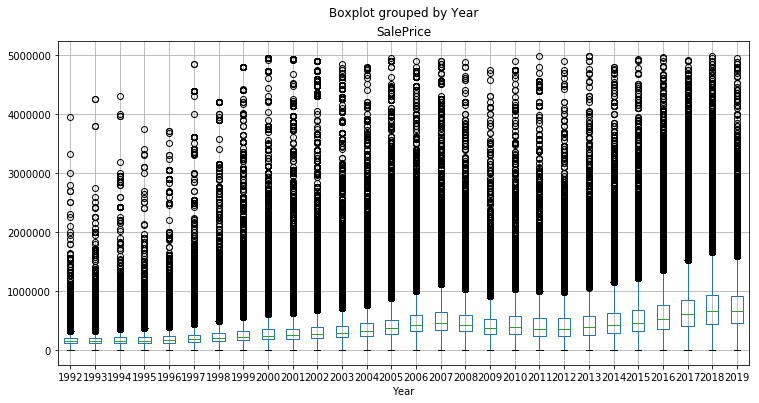

In [26]:
kc_data.boxplot(column='SalePrice', by='Year', figsize=(12,6), showfliers=True)

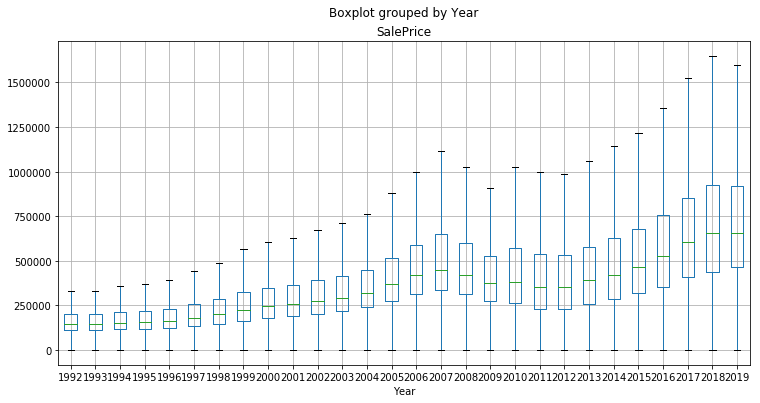

In [27]:
#observe numerous higher end outliers, view graph without outliers
kc_data.boxplot(column='SalePrice', by='Year', figsize=(12,6), showfliers=False)

In [28]:
#remove sale prices higher than 1,000,000, considered to be luxury homes, not in scope of analysis
kc_data = kc_data.loc[kc_data['SalePrice']<1000000]

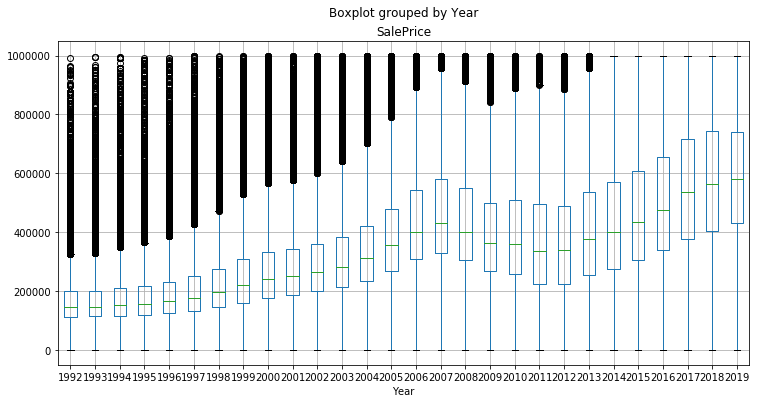

In [29]:
kc_data.boxplot(column='SalePrice', by='Year', figsize=(12,6), showfliers=True)

In [30]:
#remove low sale prices, assumed to be atypical transactions
kc_data = kc_data.loc[kc_data['SalePrice']>20000]

In [31]:
#remove properties with building grade codes 1-4, which does not meet code
#reference https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r
kc_data = kc_data.loc[kc_data['BldgGrade']>4]
kc_data = kc_data.loc[kc_data['BldgGrade']<20]

In [32]:
kc_data.BldgGrade.value_counts()

7     345053
8     231211
9      96963
6      82798
10     37958
5      10868
11     10446
12      2131
13       239
Name: BldgGrade, dtype: int64

In [33]:
#review data statistics
kc_data.describe()

,Major,Minor,SalePrice,SaleReason,NbrLivingUnits,BldgGrade,Stories,SqFtTotLiving,SqFtTotBasement,Bedrooms,YrBuilt,YrRenovated,Condition,BathCountSum,SqFtAboveGround,Year
count,817667.000000,817667.000000,817667.000000,817667.000000,817667.000000,817667.000000,817667.000000,817667.00000,817667.000000,817667.000000,817667.000000,817667.000000,817667.000000,817667.000000,817667.000000,817667.000000
mean,453603.045759,1478.959781,345449.022378,2.039394,1.018648,7.597248,1.487793,2069.32989,453.470282,3.382565,1972.313740,90.617315,3.427527,2.138711,1790.395332,2004.636101
std,287440.414073,2746.813995,207699.078561,3.491947,0.158962,1.119248,0.510112,878.58199,565.177963,0.925356,29.333173,415.694953,0.647980,0.763728,812.674913,7.768938
min,40.000000,1.000000,20011.000000,0.000000,1.000000,5.000000,1.000000,0.00000,0.000000,0.000000,1894.000000,0.000000,1.000000,0.000000,0.000000,1992.000000
25%,206480.000000,118.000000,185000.000000,1.000000,1.000000,7.000000,1.000000,1440.00000,0.000000,3.000000,1953.000000,0.000000,3.000000,1.750000,1200.000000,1998.000000
50%,388580.000000,325.000000,296100.000000,1.000000,1.000000,7.000000,1.500000,1930.00000,0.000000,3.000000,1977.000000,0.000000,3.000000,2.250000,1580.000000,2004.000000
75%,728410.000000,970.000000,454990.000000,1.000000,1.000000,8.000000,2.000000,2540.00000,930.000000,4.000000,1997.000000,0.000000,4.000000,2.500000,2240.000000,2012.000000
max,990600.000000,9692.000000,999999.000000,19.000000,11.000000,13.000000,4.000000,21650.00000,10200.000000,37.000000,2019.000000,2019.000000,5.000000,34.000000,20560.000000,2019.000000


In [34]:
#remove SqFtTot less than 500, smaller than most typical homes
kc_data = kc_data.loc[kc_data['SqFtTotLiving']>500]

In [35]:
#remove SqFtTot more than than 5000, considered exceptional properties
kc_data = kc_data.loc[kc_data['SqFtTotLiving']<5001]

In [36]:
#review data metrics
kc_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Major,809966.0,454215.765107,287478.507180,40.0,208717.50,388580.00,729799.0,990600.00
Minor,809966.0,1463.855621,2727.878254,1.0,117.00,321.00,960.0,9692.00
SalePrice,809966.0,344450.741708,206730.893985,20011.0,185000.00,295000.00,451100.0,999999.00
SaleReason,809966.0,2.036977,3.489085,0.0,1.00,1.00,1.0,19.00
NbrLivingUnits,809966.0,1.018554,0.155142,1.0,1.00,1.00,1.0,4.00
BldgGrade,809966.0,7.579008,1.084309,5.0,7.00,7.00,8.0,13.00
Stories,809966.0,1.485481,0.509446,1.0,1.00,1.50,2.0,4.00
SqFtTotLiving,809966.0,2045.139882,807.885143,504.0,1440.00,1920.00,2520.0,5000.00
SqFtTotBasement,809966.0,447.525938,553.002230,0.0,0.00,0.00,920.0,6564.00
Bedrooms,809966.0,3.378060,0.899600,0.0,3.00,3.00,4.0,33.00


In [37]:
#remove values bathrooms value less than 0.5, unlikely to be a house or outlier
kc_data = kc_data.loc[kc_data['BathCountSum'] > 0.5]

In [38]:
#remove values bathrooms value more than 5 as outlier, exceptional properties
kc_data = kc_data.loc[kc_data['BathCountSum'] <= 5]

In [39]:
kc_data.shape

(808918, 18)

In [40]:
#remove bedroom values less than 1, unlikely to be house
kc_data = kc_data.loc[kc_data['Bedrooms'] >= 1]

In [41]:
#remove bedroom values more than 10 as outliers
kc_data = kc_data.loc[kc_data['Bedrooms'] < 11]

In [42]:
kc_data.shape

(808503, 18)

In [43]:
kc_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Major,808503.0,454327.417912,287488.230059,40.00,209550.00,388580.00,729800.0,990600.0
Minor,808503.0,1462.135330,2725.817591,1.00,117.00,321.00,960.0,9692.0
SalePrice,808503.0,344384.413469,206642.211231,20011.00,185000.00,295000.00,451000.0,999999.0
SaleReason,808503.0,2.036312,3.487726,0.00,1.00,1.00,1.0,19.0
NbrLivingUnits,808503.0,1.018173,0.152934,1.00,1.00,1.00,1.0,4.0
BldgGrade,808503.0,7.578430,1.082978,5.00,7.00,7.00,8.0,13.0
Stories,808503.0,1.485051,0.509227,1.00,1.00,1.50,2.0,4.0
SqFtTotLiving,808503.0,2043.871086,805.687175,504.00,1440.00,1920.00,2520.0,5000.0
SqFtTotBasement,808503.0,447.471240,552.694197,0.00,0.00,0.00,920.0,6564.0
Bedrooms,808503.0,3.378542,0.886405,1.00,3.00,3.00,4.0,10.0


In [44]:
#basement values mostly 0, remove column
kc_data = kc_data.drop(['SqFtTotBasement'], axis=1)

In [45]:
kc_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Major,808503.0,454327.417912,287488.230059,40.00,209550.00,388580.00,729800.0,990600.0
Minor,808503.0,1462.135330,2725.817591,1.00,117.00,321.00,960.0,9692.0
SalePrice,808503.0,344384.413469,206642.211231,20011.00,185000.00,295000.00,451000.0,999999.0
SaleReason,808503.0,2.036312,3.487726,0.00,1.00,1.00,1.0,19.0
NbrLivingUnits,808503.0,1.018173,0.152934,1.00,1.00,1.00,1.0,4.0
BldgGrade,808503.0,7.578430,1.082978,5.00,7.00,7.00,8.0,13.0
Stories,808503.0,1.485051,0.509227,1.00,1.00,1.50,2.0,4.0
SqFtTotLiving,808503.0,2043.871086,805.687175,504.00,1440.00,1920.00,2520.0,5000.0
Bedrooms,808503.0,3.378542,0.886405,1.00,3.00,3.00,4.0,10.0
YrBuilt,808503.0,1972.140768,29.280175,1894.00,1952.00,1977.00,1997.0,2019.0


In [46]:
#backup data
kc_data_backup = kc_data.copy()

In [47]:
#create categorical variable for renovation
kc_data['Renovation'] = kc_data['YrRenovated'].apply(lambda x: 1 if x > 0 else 0)

In [48]:
#calculate effective age based on year built or renovations
kc_data['PptyAge'] = ((2019-kc_data.YrRenovated)*((kc_data.Renovation+1)//2) + 
                      (2019-kc_data.YrBuilt)*((kc_data.Renovation+1)%2))

In [49]:
kc_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Major,808503.0,454327.417912,287488.230059,40.00,209550.00,388580.00,729800.0,990600.0
Minor,808503.0,1462.135330,2725.817591,1.00,117.00,321.00,960.0,9692.0
SalePrice,808503.0,344384.413469,206642.211231,20011.00,185000.00,295000.00,451000.0,999999.0
SaleReason,808503.0,2.036312,3.487726,0.00,1.00,1.00,1.0,19.0
NbrLivingUnits,808503.0,1.018173,0.152934,1.00,1.00,1.00,1.0,4.0
BldgGrade,808503.0,7.578430,1.082978,5.00,7.00,7.00,8.0,13.0
Stories,808503.0,1.485051,0.509227,1.00,1.00,1.50,2.0,4.0
SqFtTotLiving,808503.0,2043.871086,805.687175,504.00,1440.00,1920.00,2520.0,5000.0
Bedrooms,808503.0,3.378542,0.886405,1.00,3.00,3.00,4.0,10.0
YrBuilt,808503.0,1972.140768,29.280175,1894.00,1952.00,1977.00,1997.0,2019.0


In [50]:
#backup data//
kc_data_backup = kc_data.copy()

In [51]:
#eliminate columns not intended to be used as features
kc_data = kc_data[['SalePrice', 'NbrLivingUnits', 'BldgGrade', 'Stories', 'SqFtTotLiving', 
                   'Bedrooms', 'BathCountSum','Condition', 'Renovation','PptyAge','Year']]

In [52]:
kc_data.head().T

,0,6,7,11,12
SalePrice,245000.0,96000.0,127500.0,464500.00,357000.00
NbrLivingUnits,1.0,1.0,1.0,1.00,1.00
BldgGrade,7.0,6.0,6.0,7.00,7.00
Stories,1.0,1.0,1.0,1.00,1.00
SqFtTotLiving,1490.0,960.0,960.0,1780.00,1780.00
Bedrooms,3.0,3.0,3.0,4.00,4.00
BathCountSum,2.0,1.0,1.0,1.75,1.75
Condition,3.0,4.0,4.0,5.00,5.00
Renovation,0.0,0.0,0.0,0.00,0.00
PptyAge,30.0,50.0,50.0,62.00,62.00


In [53]:
#split into training and test sets, using test data size 30%
kc_train, kc_test = train_test_split(kc_data, test_size=0.3)

In [54]:
kc_train.describe().T

,count,mean,std,min,25%,50%,75%,max
SalePrice,565952.0,344335.801068,206582.378653,20011.00,185000.00,295000.00,451611.25,999999.0
NbrLivingUnits,565952.0,1.018148,0.152805,1.00,1.00,1.00,1.00,4.0
BldgGrade,565952.0,7.578887,1.082959,5.00,7.00,7.00,8.00,13.0
Stories,565952.0,1.484899,0.508942,1.00,1.00,1.50,2.00,4.0
SqFtTotLiving,565952.0,2043.805487,805.771713,504.00,1440.00,1920.00,2520.00,5000.0
Bedrooms,565952.0,3.378495,0.887685,1.00,3.00,3.00,4.00,10.0
BathCountSum,565952.0,2.123958,0.718930,0.75,1.75,2.25,2.50,5.0
Condition,565952.0,3.429671,0.648046,1.00,3.00,3.00,4.00,5.0
Renovation,565952.0,0.044631,0.206492,0.00,0.00,0.00,0.00,1.0
PptyAge,565952.0,44.254239,28.628085,0.00,21.00,40.00,64.00,119.0


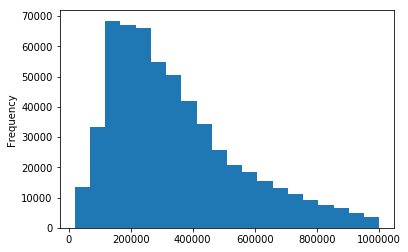

In [55]:
#view distribution of sale prices, notice skew
kc_train['SalePrice'].plot('hist', bins=20)

In [56]:
#view correlation for training data
kc_train.corr()

,SalePrice,NbrLivingUnits,BldgGrade,Stories,SqFtTotLiving,Bedrooms,BathCountSum,Condition,Renovation,PptyAge,Year
SalePrice,1.000000,0.000971,0.442524,0.274190,0.409446,0.195982,0.338137,-0.014030,0.028618,-0.174302,0.549060
NbrLivingUnits,0.000971,1.000000,-0.056791,-0.003644,0.043354,0.141994,0.086180,-0.017989,0.020865,0.100682,-0.010192
BldgGrade,0.442524,-0.056791,1.000000,0.485756,0.728763,0.346165,0.617877,-0.185102,-0.013425,-0.479059,-0.016598
Stories,0.274190,-0.003644,0.485756,1.000000,0.417094,0.217028,0.510273,-0.287414,0.001596,-0.495144,0.056106
SqFtTotLiving,0.409446,0.043354,0.728763,0.417094,1.000000,0.600047,0.735998,-0.100565,0.046503,-0.382951,-0.011280
Bedrooms,0.195982,0.141994,0.346165,0.217028,0.600047,1.000000,0.542538,-0.001557,0.010879,-0.202385,0.013035
BathCountSum,0.338137,0.086180,0.617877,0.510273,0.735998,0.542538,1.000000,-0.147082,0.035001,-0.550240,0.039634
Condition,-0.014030,-0.017989,-0.185102,-0.287414,-0.100565,-0.001557,-0.147082,1.000000,-0.078711,0.401697,0.033007
Renovation,0.028618,0.020865,-0.013425,0.001596,0.046503,0.010879,0.035001,-0.078711,1.000000,-0.170345,-0.011198
PptyAge,-0.174302,0.100682,-0.479059,-0.495144,-0.382951,-0.202385,-0.550240,0.401697,-0.170345,1.000000,-0.102915


In [57]:
#remove NbrLivingUnits and Condition due to low correlation 
#(Condition maybe better modified as categorical variable)
kc_train = kc_train.drop(['NbrLivingUnits', 'Condition'], axis=1)

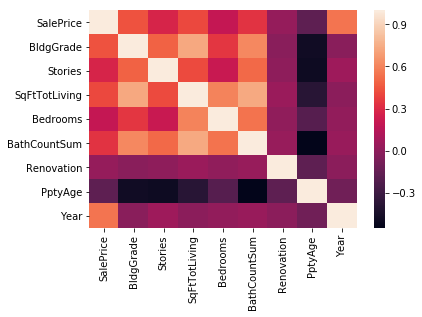

In [58]:
#visualize using correlation heatmap
sns.heatmap(kc_train.corr())

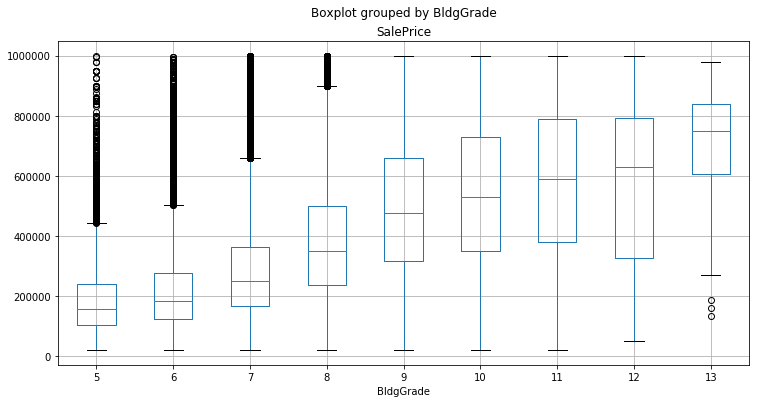

In [59]:
#view relationship between building grade and sale price
kc_train.boxplot(column='SalePrice', by='BldgGrade', figsize=(12,6), showfliers=True)

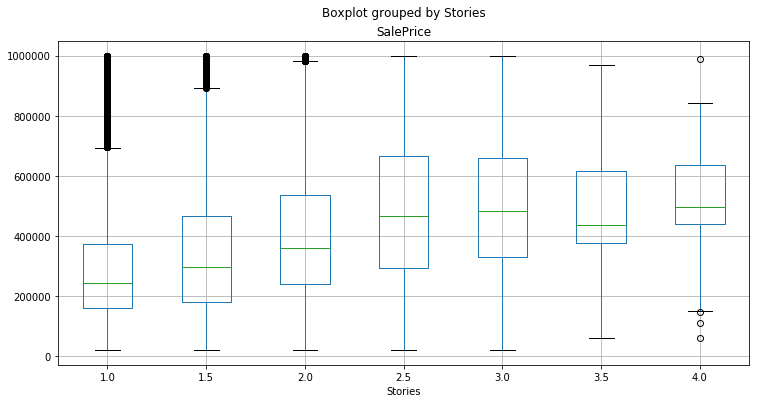

In [60]:
kc_train.boxplot(column='SalePrice', by='Stories', figsize=(12,6), showfliers=True)

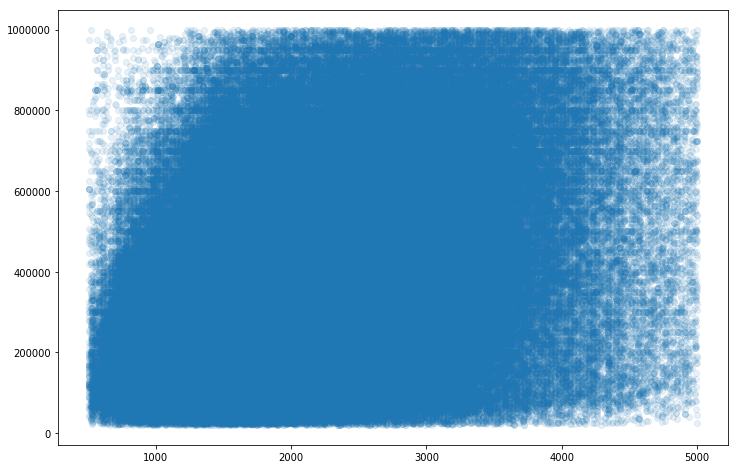

In [126]:
#scatterplot with total square feet and sale price
plt.figure(figsize=(12,8))
plt.scatter(kc_train.SqFtTotLiving, kc_train.SalePrice, alpha=0.1)

In [62]:
#separate features and dependant variable
kc_train_features = kc_train.drop(['SalePrice'], axis=1)
kc_train_price = kc_train['SalePrice']

In [63]:
#create variables to fit regression model
x = kc_train_features
y = kc_train_price

In [64]:
predictors_int = sm.add_constant(x)
model = sm.OLS(y,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                 8.485e+04
Date:                Fri, 12 Jul 2019   Prob (F-statistic):               0.00
Time:                        09:40:57   Log-Likelihood:            -7.5064e+06
No. Observations:              565952   AIC:                         1.501e+07
Df Residuals:                  565943   BIC:                         1.501e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.087e+07   4.84e+04   -637.874      0.000    -3.1e+07   -3.08e+07
BldgGrade      6.858e+04    274.244    250.074      0.000     6.8e+04    6.91e+04
Stories        2.775e+04    454.328     61.069      0.000    2.69e+04    2.86e+04
SqFtTotLiving    49.1927      0.438    112.194      0.000      48.333      50.052
Bedrooms      -1.282e+04    272.538    -47.026      0.000   -1.34e+04   -1.23e+04
BathCountSum    1.44e+04    442.789     32.522      0.000    1.35e+04    1.53e+04
Renovation     6.227e+04    922.845     67.471      0.000    6.05e+04    6.41e+04
PptyAge        1379.7120      8.583    160.743      0.000    1362.889    1396.535
Year           1.522e+04     24.058    632.537      0.000    1.52e+04    1.53e+04
==============================================================================
Omnibus:                    44367.195   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           149549.843
Skew:                           0.376   Prob(JB):                         0.00
Kurtosis:                       5.404   Cond. No.                     7.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
#mean squared error
model.mse_model

1646381986690129.5

In [73]:
#run model using sklearn
ss = StandardScaler()

ss.fit(kc_train_features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [75]:
kc_train_scaled = ss.transform(kc_train_features)

In [76]:
kc_lr = LinearRegression()
kc_lr.fit(kc_train_scaled, kc_train_price)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [77]:
kc_lr.coef_

array([ 74270.69238237,  14120.81809281,  39638.07450841, -11376.91043893,
        10352.71803739,  12857.32134865,  39498.47823013, 118260.51604672])

In [79]:
kc_test_features = kc_test[['BldgGrade', 'Stories', 'SqFtTotLiving', 'Bedrooms', 'BathCountSum',
               'Renovation', 'PptyAge','Year']]
kc_test_price = kc_test['SalePrice']

In [83]:
kc_lr.score(ss.transform(kc_test_features), kc_test_price)

0.541801059126817

In [84]:
kc_pred_price = kc_lr.predict(kc_test_features)

In [85]:
#mean squared absolute error
metrics.mean_absolute_error(kc_test_price, kc_pred_price)

320409002.4376401

In [86]:
metrics.mean_squared_error(kc_test_price, kc_pred_price)

1.036531562559462e+17

In [ ]:
#Improve model by log transformation

In [89]:
#log transform sale price and rerun regression model
kc_train_price_log = np.log(kc_train_price)

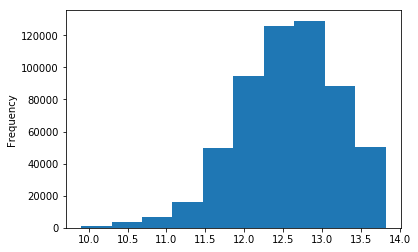

In [101]:
#log sale price distribution more normal
kc_train_price_log.plot('hist')

In [90]:
#rerun regression model using sklearn package
kc_lr2 = LinearRegression()
kc_lr2.fit(kc_train_scaled, kc_train_price_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [105]:
kc_lr2.coef_

array([ 0.22214152,  0.04236541,  0.09182596, -0.02149585,  0.04078051,
        0.03238046,  0.11625417,  0.37942023])

In [92]:
kc_test_price_log = np.log(kc_test_price)

In [93]:
kc_lr2.score(ss.transform(kc_test_features), kc_test_price_log)

0.5249963663948964

In [108]:
kc_pred_price_log = kc_lr2.predict(ss.transform(kc_test_features))

In [109]:
kc_pred_price_log[:10]

array([13.35882074, 12.49199892, 11.95026871, 12.88123572, 13.57145582,
       12.5753077 , 11.73907642, 12.94556939, 12.6743867 , 13.11800454])

In [99]:
#revert log transformation
kc_pred_price = np.exp(kc_pred_price_log)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [110]:
kc_pred_price = np.exp(kc_pred_price_log)

In [111]:
#mean absolute error
metrics.mean_absolute_error(kc_test_price, kc_pred_price)

99072.06846519037

In [112]:
metrics.mean_squared_error(kc_test_price, kc_pred_price)

20534283918.02853

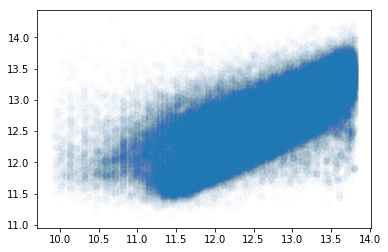

In [125]:
plt.scatter(kc_test_price_log, kc_pred_price_log, alpha=0.01)

####Next Steps to improve model

- incorporate location data
- more detailed data processing (i.e. inspect and remove outliers on yearly basis)
- drop variables not significant to the regression
- run model validation processes to further improve model
- Explore other types of models other than linear regression